In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
    de_testing = "NEIGHBORHOOD"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as plasmid_positive, all others as plasmid_negative

In [6]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "plasmid_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "plasmid_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [7]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [8]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [9]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [10]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 1

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 796

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

# Check DE for genes near SNPs

In [15]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

## Load neighbors list

In [16]:
neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")

# Run diffex on pseudobulked samples using EdgeR

This version ran DE testing on all genes. If you want to include only the neighbors, use: markers <- qlf$table[neighbors, ] %>% arrange(PValue)

In [17]:
library(edgeR)

In [42]:
df_targets = unique(filter(df_guide, subclass=='ckd_de'))
df_targets = unique(filter(df_guide, class=='targeting'))
#df_targets = unique(filter(df_guide, alias=='FTH1'))
df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01

cat(red("!! Diffex is performed vector_positive vs vector_negative.\n"))
cat(red("!! USE vector_positive vs target_negative instead.\n\n"))

for(i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    vector_id       = gsub("a", "", df_targets[i, 'guide1'])
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        is_de = FALSE
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    guides_on_plasmid = unlist(as.list(t(df_targets[i, c('guide1', 'guide2')])))
    cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")

    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,        
        perturbed_cells_by_guide, 
        guides_on_plasmid,
        print_counts = T,
        pos_label = "plasmid_positive",
        neg_label = "plasmid_negative"
    )    
    if("plasmid_positive" %in% levels((Idents(seurat_dummy)))) {
        seurat_dummy$perturbation_status = Idents(seurat_dummy)
        #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
        #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
        seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
        print(table(filter(seurat_dummy@meta.data, perturbation_status == 'plasmid_positive')$donor) )


        # Use each donor as a replicate
        cluster_list = as.character(seurat_dummy$perturbation_status)
        cluster_list[cluster_list == "plasmid_negative"] = 1
        cluster_list[cluster_list == "plasmid_positive"] = 0
        seurat_dummy$cluster = as.factor(cluster_list)
        y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

        # Add target+/- counts to df_cell_counts
        if(!is_de) {
            df_dummy = as.data.frame(y$counts[target,])
            colnames(df_dummy) = "count"
            df_dummy$target <- target
            df_dummy$label = rownames(df_dummy)
            df_dummy$vector = vector_id
            df_samples = y$samples
            df_dummy = merge(df_dummy, df_samples, by = 0)
            df_cell_counts = rbind(df_cell_counts, df_dummy)
        }

        # Filter out small samples, lowly expressed genes.
        keep.samples <- y$samples$lib.size > 5e4
        table(keep.samples)
        y <- y[, keep.samples]
        keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
        table(keep.genes)
        y <- normLibSizes(y)

        # Create design matrix
        donor <- factor(y$samples$sample)
        cluster <- as.factor(y$samples$cluster)
        design <- model.matrix(~ cluster + donor)
        colnames(design) <- gsub("donor", "", colnames(design))
        colnames(design)[1] <- "Int"

        ncls <- nlevels(cluster)
        contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
        diag(contr) <- 1
        contr[1,] <- 0
        rownames(contr) <- colnames(design)
        colnames(contr) <- paste0("cluster", levels(cluster))
        
        # Estimate dispersion
        y <- estimateDisp(y, design, robust=TRUE)
        y$common.dispersion

        # Fit
        fit <- glmQLFit(y, design, robust=TRUE)
        qlf <- glmQLFTest(fit, contrast=contr[,1])
        
        if(de_testing == "NEIGHBORHOOD") {
            markers <- qlf$table[neighbors, ] %>% arrange(PValue)
        } else { 
            # Test all genes
            markers <- qlf$table %>% arrange(PValue)
        }

        if(nrow(markers) == 0) {
            cat(red("No DE genes", target,  "\n"))
            next
        } 
      
        markers$de_gene = rownames(markers)
        markers$target = target
        markers$subclass = target_subclass
        markers$label = label
        markers$plasmid = gsub("a", "", guides_on_plasmid[[1]])
        rownames(markers) <- NULL
        df_neighbor_de = rbind(df_neighbor_de, markers)
        print(head(markers))
        cat("-------------------------------------------------------\n\n")
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
}


!! Diffex is performed vector_positive vs vector_negative.
!! USE vector_positive vs target_negative instead.



ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 

donor0 donor1 donor2 donor3 
   270    233    385    273 
  logFC logCPM    F   PValue de_gene target subclass       label plasmid
1 -1.32    6.9 1122 2.6e-207   ANPEP  ANPEP      tss Control TSS  CD13-1
2 -0.33    6.7   76  2.5e-18    IDH2  ANPEP      tss Control TSS  CD13-1
3 -0.20    6.7   27  1.8e-07  SEMA4B  ANPEP      tss Control TSS  CD13-1
4  0.23    5.4   23  1.5e-06   AP3S2  ANPEP      tss Control TSS  CD13-1
5  0.21    5.4   19  1.5e-05   MFGE8  ANPEP      tss Control TSS  CD13-1
6 -0.36    3.5   15  1.2e-04   FANCI  ANPEP      tss Control TSS  CD13-1
-------------------------------------------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26061 

donor0 donor1 donor2 donor3 
   253    220    319    289 
  logFC logCPM     F  PValue  de_gene target subclass       label plasmid
1 -2.20    4.1 432.1 8.8e-96     CD55   CD55      tss Control TSS

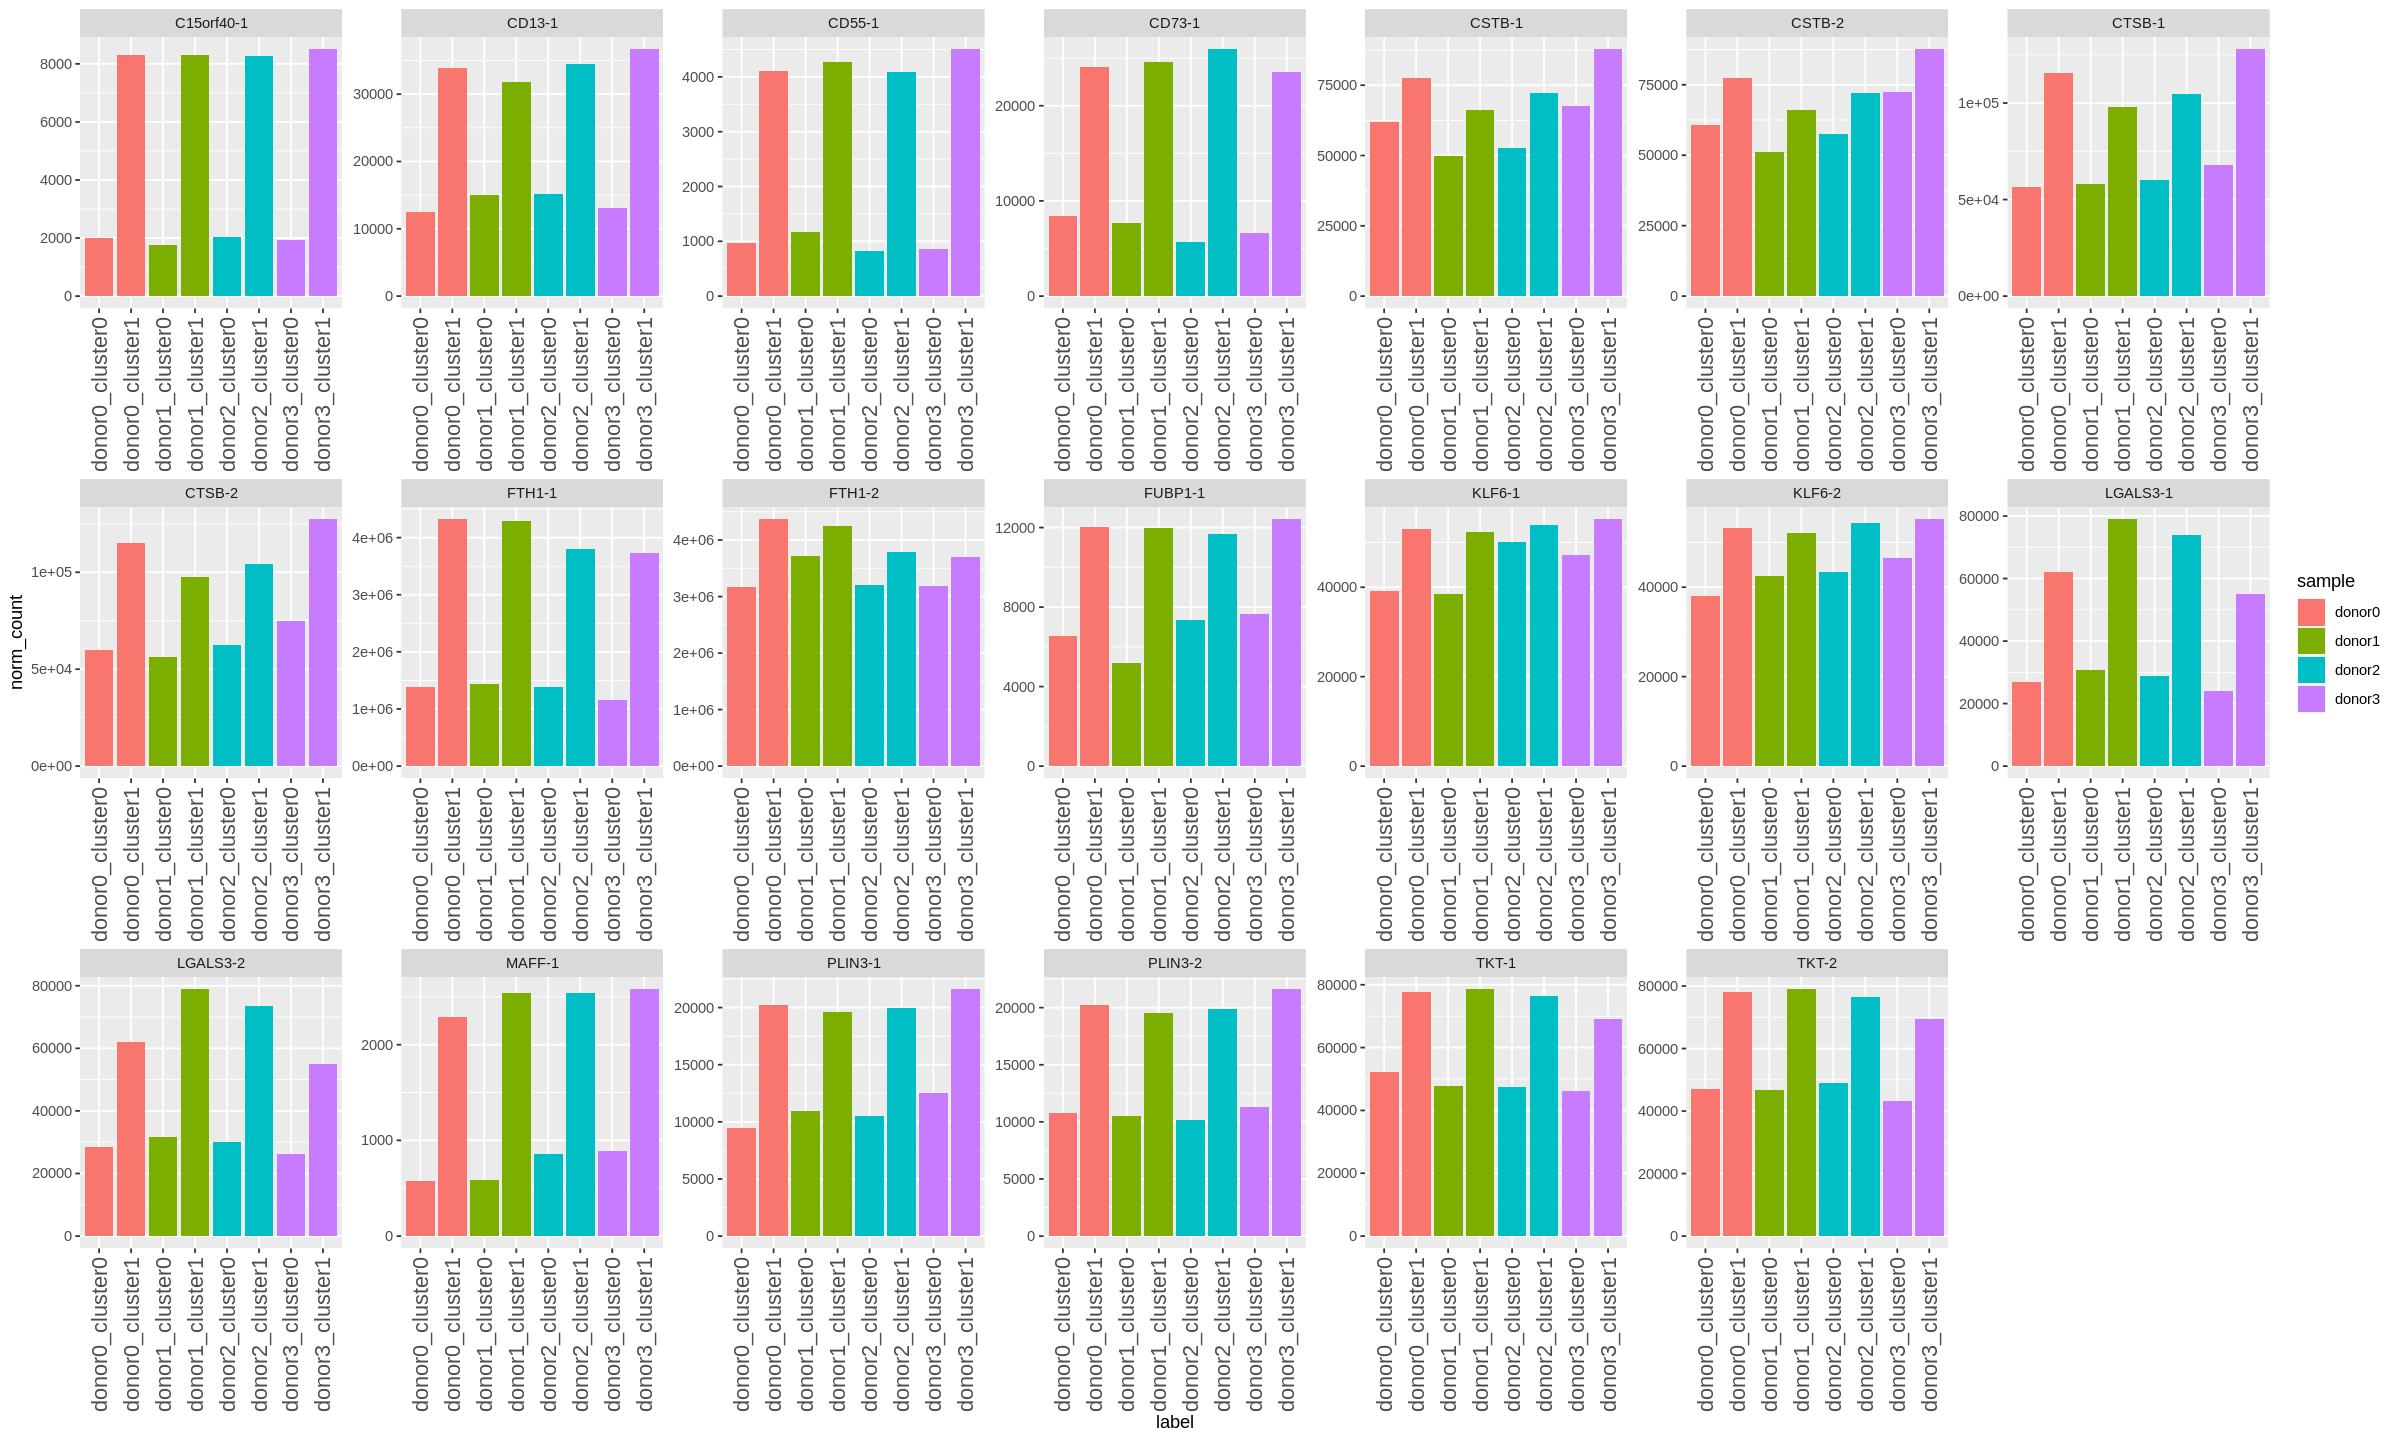

In [43]:
df_cell_counts$label = str_replace(df_cell_counts$label, "_clusterplasmid_positive", "(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "_clusterplasmid_negative", "(-)")

df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

# options(repr.plot.width=15, repr.plot.height=6)
# ggplot(df_cell_counts, aes(label)) +
#     geom_bar(aes(weight=norm_count)) +
#     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
#     facet_wrap(~ target, scales="free", ncol = 7)

options(repr.plot.width=20, repr.plot.height=12)
ggplot(df_cell_counts, aes(x = label, y = norm_count, fill = sample))+
     geom_bar(position="stack", stat="identity")  +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
    facet_wrap(~ vector, scales="free", ncol = 7)

df_cell_counts_only_plus_minus = df_cell_counts %>% filter()

In [44]:
head(df_cell_counts, 8)

,Row.names,count,target,label,vector,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,388,ANPEP,donor0_cluster0,CD13-1,1,6.9e+06,1,donor0,0,12474
2,donor0_cluster1,24813,ANPEP,donor0_cluster1,CD13-1,1,1.6e+08,1,donor0,1,33842
3,donor1_cluster0,533,ANPEP,donor1_cluster0,CD13-1,1,7.9e+06,1,donor1,0,15001
4,donor1_cluster1,25027,ANPEP,donor1_cluster1,CD13-1,1,1.7e+08,1,donor1,1,31867
5,donor2_cluster0,835,ANPEP,donor2_cluster0,CD13-1,1,1.2e+07,1,donor2,0,15111
6,donor2_cluster1,33783,ANPEP,donor2_cluster1,CD13-1,1,2.2e+08,1,donor2,1,34475
7,donor3_cluster0,466,ANPEP,donor3_cluster0,CD13-1,1,7.9e+06,1,donor3,0,13133
8,donor3_cluster1,28657,ANPEP,donor3_cluster1,CD13-1,1,1.7e+08,1,donor3,1,36649


## Inpect DE results

Print top high-confidence hits

In [45]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-1.64,13.6,4405,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1
2,-1.32,7.8,1657,0.0e+00,LGALS3,LGALS3,de_control,Control DE,LGALS3-1
3,-1.24,7.8,1254,7.3e-271,LGALS3,LGALS3,de_control,Control DE,LGALS3-2
4,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1
5,-0.84,8.7,908,3.1e-197,CTSB,CTSB,de_control,Control DE,CTSB-2
6,-0.91,8.6,887,3.4e-189,CTSB,CTSB,de_control,Control DE,CTSB-1
7,-2.14,4.9,790,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1
8,-1.85,6.4,1291,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1
9,-0.92,6.0,573,2.7e-126,NDRG1,DE6,ckd_de,CKD DE,DE6-2


In [46]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-1.32,6.91,1122.3,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1
2,-2.14,4.94,790.1,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1
3,-1.85,6.37,1290.8,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1
4,-2.20,4.06,432.1,8.8e-96,CD55,CD55,tss,Control TSS,CD55-1
5,-0.86,5.59,246.5,5.1e-55,FUBP1,FUBP1,tss,Control TSS,FUBP1-1
6,-1.82,3.37,167.0,3.5e-38,MAFF,MAFF,tss,Control TSS,MAFF-1
7,-0.33,6.66,76.3,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1
8,-0.19,10.47,57.9,2.7e-14,LGALS1,MAFF,tss,Control TSS,MAFF-1
9,-0.20,6.72,27.3,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1


In [47]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-0.92,6.01,573,2.7e-126,NDRG1,DE6,ckd_de,CKD DE,DE6-2
2,-1.10,5.99,577,9.5e-101,NDRG1,DE6,ckd_de,CKD DE,DE6-1
3,-0.49,8.28,343,1.5e-76,RBPMS,DE15,ckd_de,CKD DE,DE15-2
4,-0.46,8.29,262,6.0e-59,RBPMS,DE15,ckd_de,CKD DE,DE15-1
5,-0.71,4.91,153,4.1e-35,STC1,DE7,ckd_de,CKD DE,DE7-1
6,-0.82,4.79,210,1.1e-32,CCNB1,DE4,ckd_de,CKD DE,DE4-1
7,-0.83,4.77,141,1.6e-32,CCNB1,DE4,ckd_de,CKD DE,DE4-2
8,-0.44,6.46,104,2.8e-24,PKHD1,DE16,ckd_de,CKD DE,DE16-1
9,-0.36,5.55,62,3.3e-15,LOXL2,DE7,ckd_de,CKD DE,DE7-1


In [48]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
-1.64,13.6,4405,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1
-1.27,3.4,103,3.3e-24,BEST1,FTH1,de_control,Control DE,FTH1-1
-0.43,5.2,47,5.6e-12,FADS3,FTH1,de_control,Control DE,FTH1-1
-0.40,4.7,94,2.8e-22,FADS2,FTH1,de_control,Control DE,FTH1-2
-0.22,8.3,91,1.8e-21,AHNAK,FTH1,de_control,Control DE,FTH1-2
0.23,6.5,73,1.6e-17,SLC3A2,FTH1,de_control,Control DE,FTH1-2
-0.25,6.0,71,4.3e-17,ASRGL1,FTH1,de_control,Control DE,FTH1-2
-0.94,6.3,501,9.7e-111,PLIN3,PLIN3,de_control,Control DE,PLIN3-1
-0.95,6.3,404,9.7e-90,PLIN3,PLIN3,de_control,Control DE,PLIN3-2


In [49]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
804,-1.1041,5.990,577.358,9.5e-101,NDRG1,DE6,ckd_de,CKD DE,DE6-1
805,0.0634,6.147,2.567,1.1e-01,PHF20L1,DE6,ckd_de,CKD DE,DE6-1
806,0.8369,-2.137,2.341,1.3e-01,HPYR1,DE6,ckd_de,CKD DE,DE6-1
807,0.0602,4.452,0.925,3.4e-01,KCNQ3,DE6,ckd_de,CKD DE,DE6-1
808,0.1016,2.530,0.746,3.9e-01,TG,DE6,ckd_de,CKD DE,DE6-1
809,-0.2310,-0.042,0.566,4.5e-01,CCN4,DE6,ckd_de,CKD DE,DE6-1
810,0.1465,-0.625,0.170,6.8e-01,TMEM71,DE6,ckd_de,CKD DE,DE6-1
811,0.1176,-0.098,0.159,6.9e-01,SLA,DE6,ckd_de,CKD DE,DE6-1
812,0.0056,6.767,0.025,8.7e-01,ST3GAL1,DE6,ckd_de,CKD DE,DE6-1


,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1099,-0.4603,8.29,2.6e+02,6.0e-59,RBPMS,DE15,ckd_de,CKD DE,DE15-1
1100,-0.4924,1.03,4.2e+00,3.9e-02,TEX15,DE15,ckd_de,CKD DE,DE15-1
1101,0.8406,-1.52,3.3e+00,7.1e-02,LINC00589,DE15,ckd_de,CKD DE,DE15-1
1102,0.2034,2.73,3.2e+00,7.6e-02,RBPMS-AS1,DE15,ckd_de,CKD DE,DE15-1
1103,0.0813,5.54,2.9e+00,8.9e-02,LEPROTL1,DE15,ckd_de,CKD DE,DE15-1
1104,1.2010,-3.04,2.4e+00,1.2e-01,LINC02099,DE15,ckd_de,CKD DE,DE15-1
1105,1.1097,-2.88,2.3e+00,1.3e-01,PURG,DE15,ckd_de,CKD DE,DE15-1
1106,0.6937,-1.93,1.6e+00,2.1e-01,MBOAT4,DE15,ckd_de,CKD DE,DE15-1
1107,-0.0642,4.94,1.2e+00,2.7e-01,WRN,DE15,ckd_de,CKD DE,DE15-1


## Volcano Plot

In [50]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


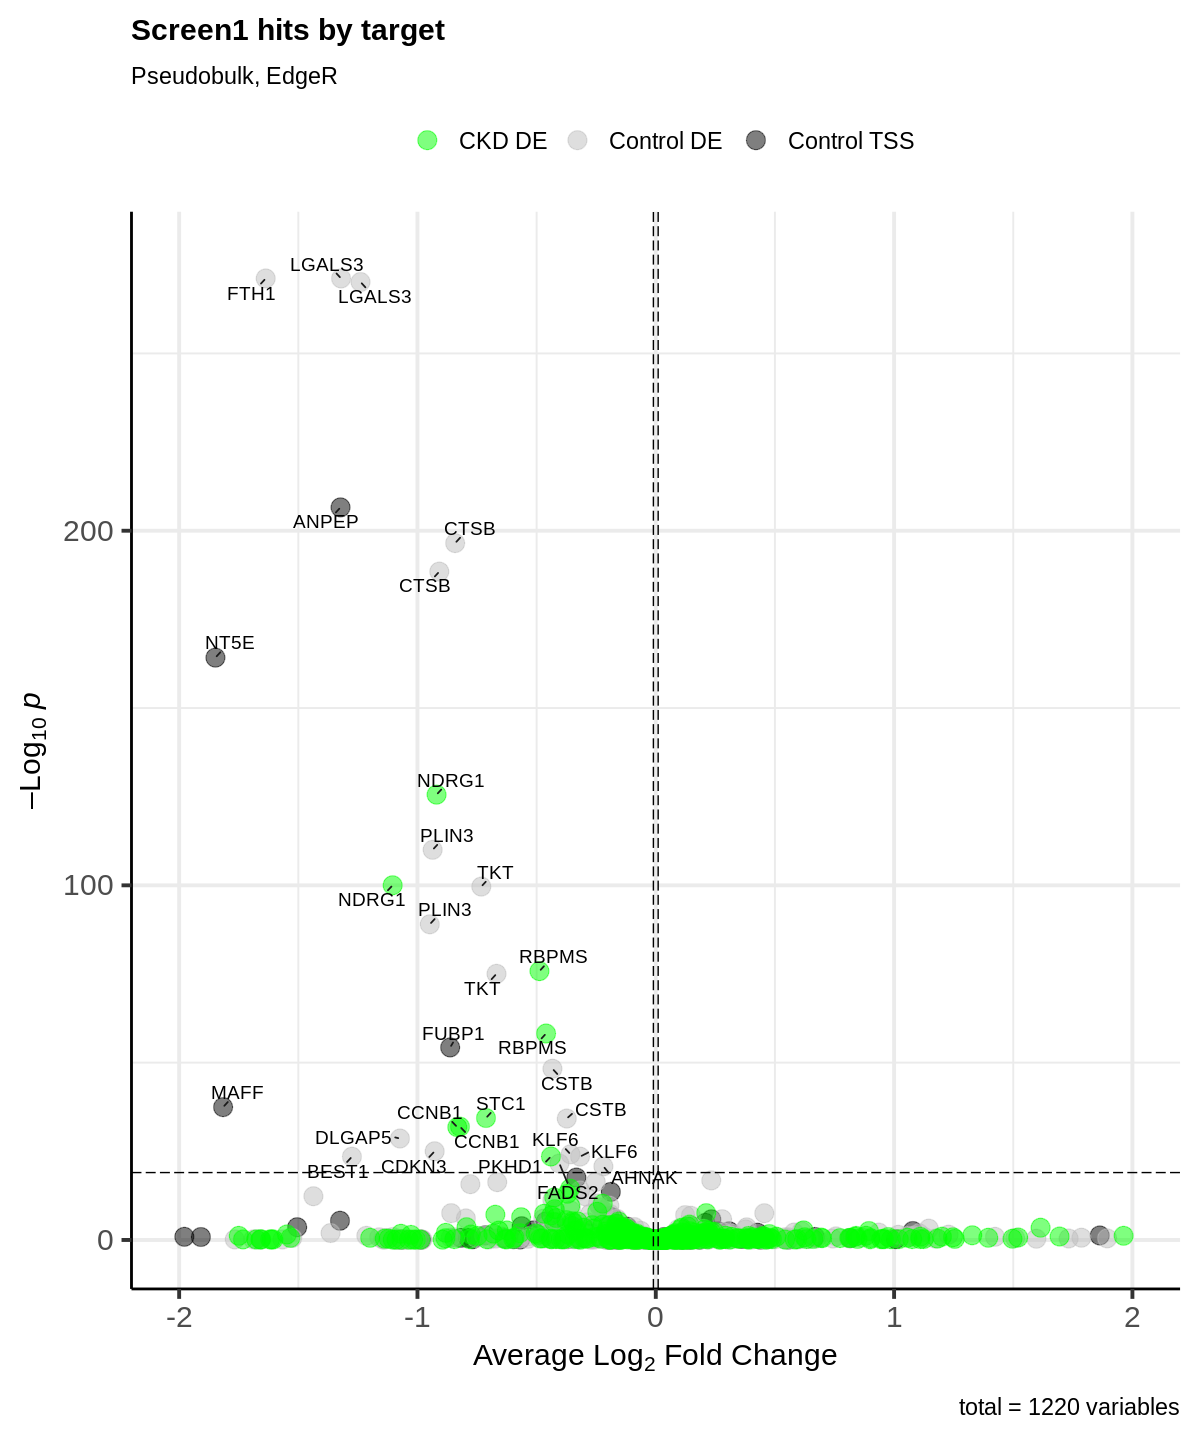

In [51]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, "hits by target"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-20,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


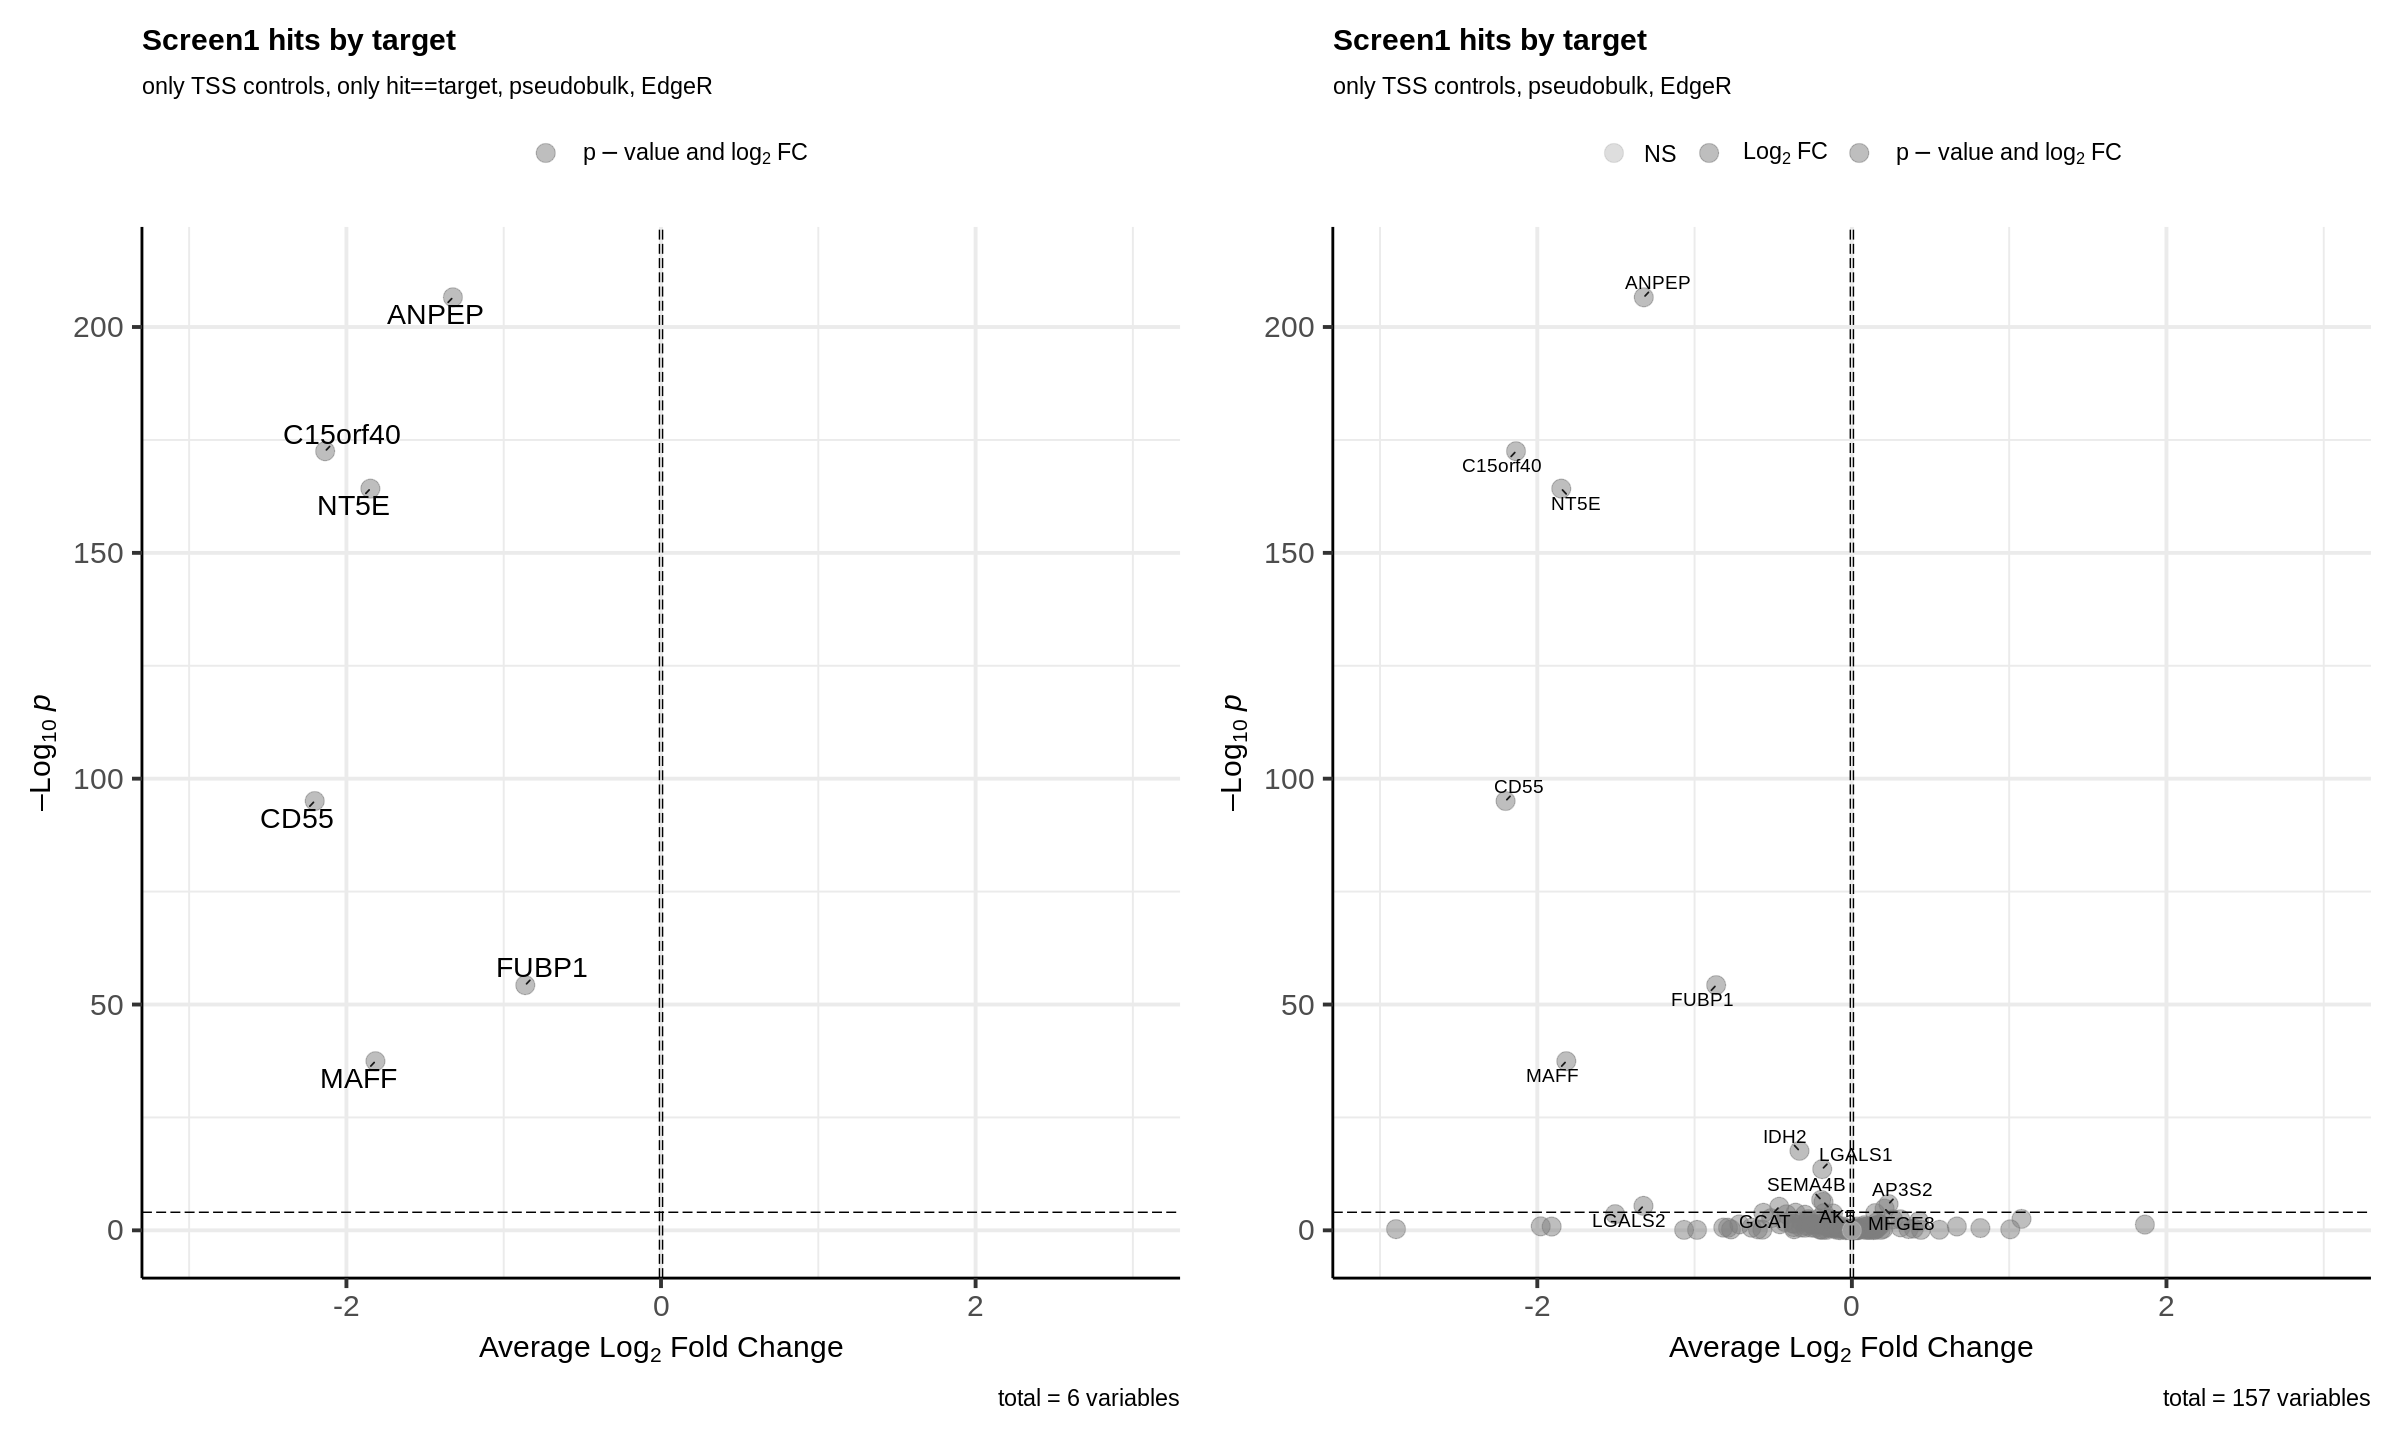

In [52]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [53]:
head(df_neighbor_de_subset)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,CD13-1


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 48 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


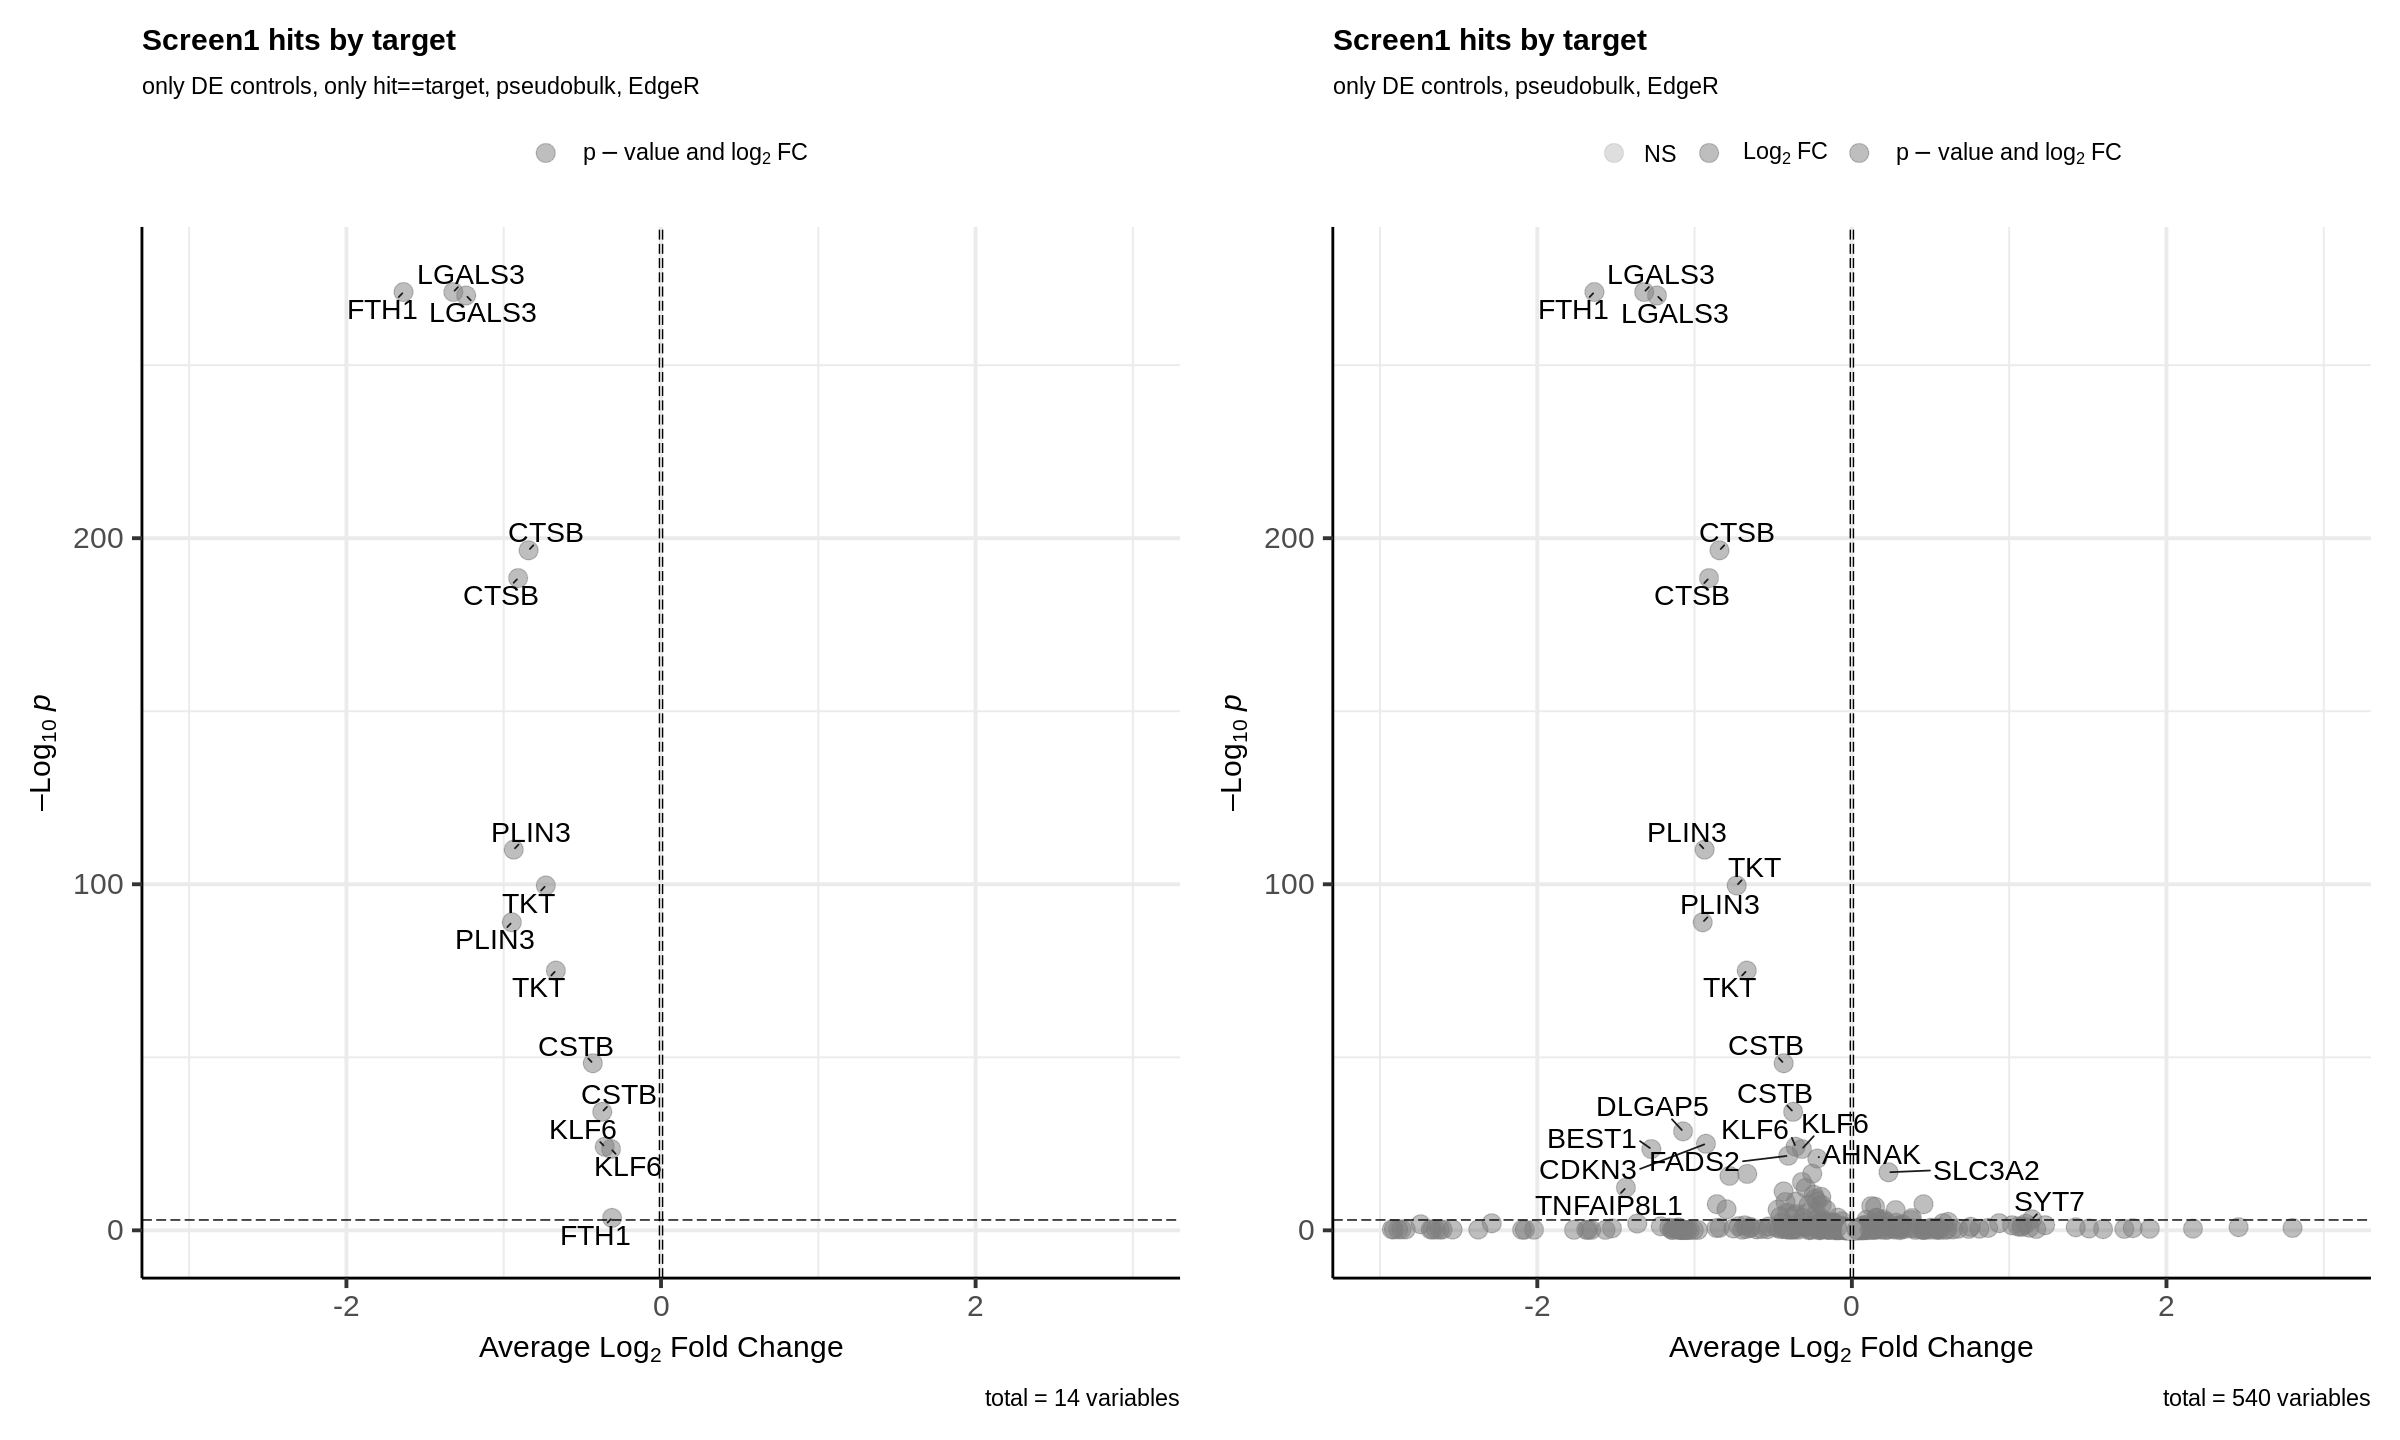

In [54]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 40 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


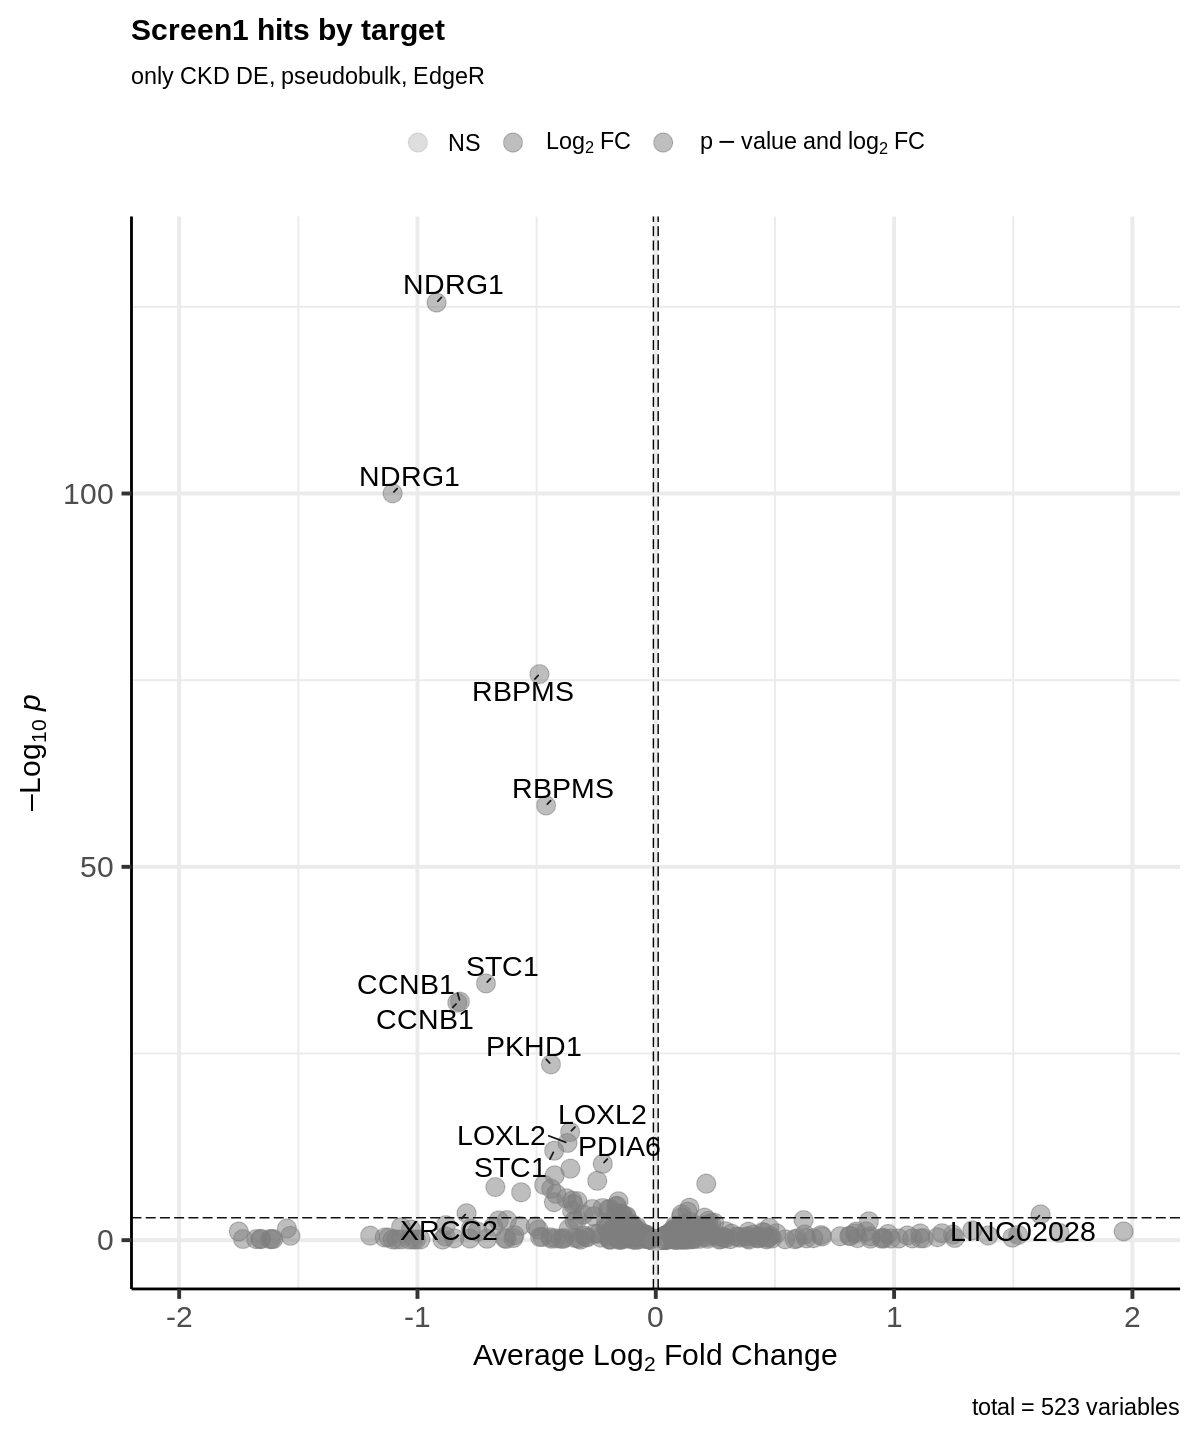

In [55]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inspect further

In [56]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC < 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-0.92,6.01,573,2.7e-126,NDRG1,DE6,ckd_de,CKD DE,DE6-2
2,-1.10,5.99,577,9.5e-101,NDRG1,DE6,ckd_de,CKD DE,DE6-1
3,-0.49,8.28,343,1.5e-76,RBPMS,DE15,ckd_de,CKD DE,DE15-2
4,-0.46,8.29,262,6.0e-59,RBPMS,DE15,ckd_de,CKD DE,DE15-1
5,-0.71,4.91,153,4.1e-35,STC1,DE7,ckd_de,CKD DE,DE7-1
6,-0.82,4.79,210,1.1e-32,CCNB1,DE4,ckd_de,CKD DE,DE4-1
7,-0.83,4.77,141,1.6e-32,CCNB1,DE4,ckd_de,CKD DE,DE4-2
8,-0.44,6.46,104,2.8e-24,PKHD1,DE16,ckd_de,CKD DE,DE16-1
9,-0.36,5.55,62,3.3e-15,LOXL2,DE7,ckd_de,CKD DE,DE7-1


# Visualize

# Redundant